https://towardsdatascience.com/data-driven-growth-with-python-part-1-know-your-metrics-812781e66a5b DATA DRIVEN GROWTH WITH PYTHON Know Your Metrics Learn what and how to track with Python

## Importing useful libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
import seaborn as sns
%matplotlib inline
import xlsxwriter
import datetime as dt
from datetime import datetime, timedelta
import missingno as msno
import plotly.offline as pyoff
import plotly.graph_objs as go
#initiate plotly
pyoff.init_notebook_mode()

## Import machine learning related libraries

In [2]:
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, Ridge, LinearRegression
from sklearn.metrics import mean_squared_error,classification_report,confusion_matrix,r2_score,roc_curve, roc_auc_score
from sklearn.utils import resample
from sklearn.model_selection import validation_curve, learning_curve, ShuffleSplit, KFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.datasets import load_digits
import xgboost as xgb
from sklearn.datasets import fetch_california_housing
from mlxtend.evaluate import bias_variance_decomp
from sklearn.impute import SimpleImputer

In [3]:
import os

print("Path at terminal when executing this file")
print(os.getcwd() + "\n")

Path at terminal when executing this file
C:\Users\Admin\Documents\GFK



In [4]:
# to ignore Warning msgs:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

## 0. Data Preparation

In [5]:
df_train = pd.read_csv('GFK training2.csv',keep_default_na = True, encoding='latin-1')
df_train["classLabel"]= np.where(df_train["classLabel"] == "no.", 0, 1)
print(df_train.shape)

(3700, 18)


## Drop dataframe columns with only one distinct value:

In [45]:
for col in df_train.columns:
    if len(df_train[col].unique()) == 1:
        df_train[col] = df_train.drop(col,inplace=True,axis=1)
        print('Col with only one distinct value: ' , df_train[col])

## Closser look at dataframe:

In [47]:
print(df_train.dropna().nunique())

v1               2
v2             163
v3             108
v4               3
v5            1463
v6            1463
v7              78
v8               2
v9               2
v10             19
v11              2
v12              3
v13             78
v14             85
v15             78
v16              2
v17              2
classLabel       2
dtype: int64


In [54]:
for col in df_train.columns:
    if df_train[col].nunique() < 5:
        print(df_train[col].value_counts())

b    4553
a    2182
Name: v1, dtype: int64
u    5210
y    1542
l      32
Name: v4, dtype: int64
t    3779
f    3069
Name: v8, dtype: int64
f    3873
t    2975
Name: v9, dtype: int64
f    3819
t    3029
Name: v11, dtype: int64
g    6205
s     551
p      92
Name: v12, dtype: int64
f    1683
t    1414
Name: v16, dtype: int64
0    3424
1    3424
Name: v17, dtype: int64
0    3424
1    3424
Name: classLabel, dtype: int64


# Hundle Imbalanced Classes:

https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/

#### Advantage and disadvantages of Under-sampling
>  Advantages
It can help improve run time and storage problems by reducing the number of training data samples when the training data set is huge.

>  Disadvantages
It can discard potentially useful information which could be important for building rule classifiers.
The sample chosen by random under-sampling may be a biased sample. And it will not be an accurate representation of the population. Thereby, resulting in inaccurate results with the actual test data set.

#### Advantages and Disadvantage of over-sampling
> Advantages
Unlike under-sampling, this method leads to no information loss.
Outperforms under sampling

> Disadvantages
It increases the likelihood of overfitting since it replicates the minority class events.

In [7]:
# Separate majority and minority classes
df_majority = df_train[df_train["classLabel"]==1]
df_minority = df_train[df_train["classLabel"]==0]

# Get majority class (1)
L = df_train["classLabel"].loc[df_train['classLabel'] == 1].value_counts()

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples= L.iloc[0],    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled["classLabel"].value_counts()

0    3424
1    3424
Name: classLabel, dtype: int64

In [8]:
df_train = df_upsampled.copy()

<AxesSubplot:>

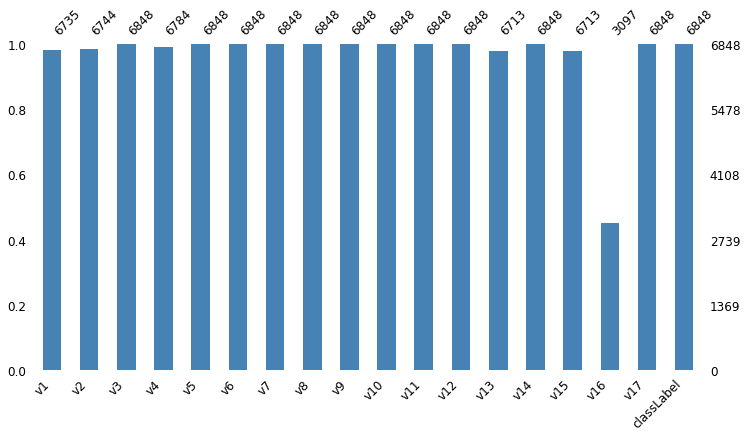

In [9]:
msno.bar(df_train, figsize=(12, 6), fontsize=12, color='steelblue')

In [10]:
imputer = SimpleImputer(strategy='most_frequent')
imputed_df = pd.DataFrame(imputer.fit_transform(df_train))
imputed_df.columns = df_train.columns

<AxesSubplot:>

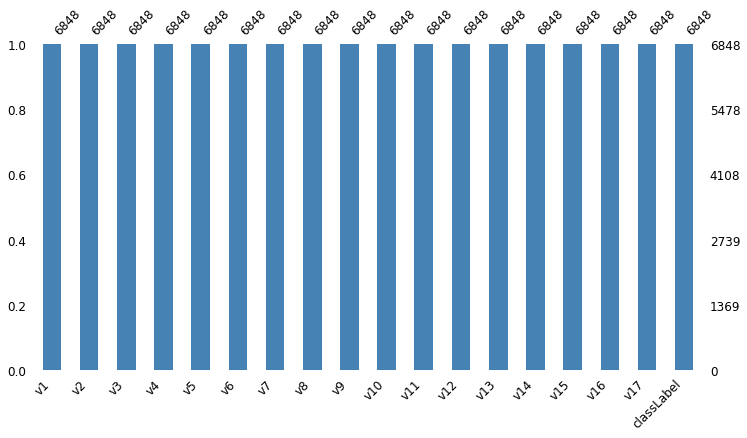

In [11]:
msno.bar(imputed_df, figsize=(12, 6), fontsize=12, color='steelblue')

In [12]:
df_train.columns.to_series().groupby(df_train.dtypes).groups

{int32: ['classLabel'], int64: ['v10', 'v14', 'v17'], float64: ['v2', 'v3', 'v5', 'v6', 'v7', 'v13', 'v15'], object: ['v1', 'v4', 'v8', 'v9', 'v11', 'v12', 'v16']}

In [13]:
imputed_df.select_dtypes(include=['object']).columns

Index(['v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11',
       'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'classLabel'],
      dtype='object')

In [14]:
#df_test = pd.read_csv('GFK validation2.csv',keep_default_na = True, encoding='latin-1')
#df_test["classLabel"]= np.where(df_test["classLabel"] == "no.", 0, 1)
#imputed_df_t = pd.DataFrame(imputer.fit_transform(df_test))
#imputed_df_t.columns = df_test.columns

# OneHotEncoder to deal with missing categories in the validation table

> I is missing in v4 validation table


> O is extra in v12 validation table

In [15]:
object_cols = df_train.select_dtypes(include=['object']).columns
low_cardinality_cols = [col for col in object_cols if df_train[col].nunique() < 10]
high_cardinality_cols = list(set(object_cols)-set(low_cardinality_cols))

In [16]:
low_cardinality_cols

['v1', 'v4', 'v8', 'v9', 'v11', 'v12', 'v16']

In [17]:
# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False) # Cannot use drop='first' with handle_unknown
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(imputed_df[low_cardinality_cols]))
#OH_cols_valid = pd.DataFrame(OH_encoder.transform(imputed_df_t[low_cardinality_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = imputed_df.index
#OH_cols_valid.index = imputed_df_t.index

# One-hot encoding removed columns' names; put it back
OH_cols_train.columns = OH_encoder.get_feature_names(low_cardinality_cols)
#OH_cols_valid.columns = OH_encoder.get_feature_names(low_cardinality_cols)

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = imputed_df.drop(object_cols, axis=1)
#num_X_valid = imputed_df_t.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
#OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

#print(OH_encoder.categories_)
#print(OH_X_train.columns)
#print(OH_X_valid.columns)

In [18]:
#low_cardinality_cols = transformed.select_dtypes(include=['object']).columns
for object_col in OH_X_train:
    OH_X_train[object_col] = OH_X_train[object_col].astype(float, errors = 'raise')
#for object_col in OH_X_valid:
#    OH_X_valid[object_col] = OH_X_valid[object_col].astype(float, errors = 'raise')

In [19]:
Cols = OH_X_train.columns
for col in OH_X_train:
    print(col, OH_X_train[col].nunique())

v2 288
v3 179
v5 3700
v6 3700
v7 118
v10 23
v13 136
v14 182
v15 136
v17 2
classLabel 2
v1_a 2
v1_b 2
v4_l 2
v4_u 2
v4_y 2
v8_f 2
v8_t 2
v9_f 2
v9_t 2
v11_f 2
v11_t 2
v12_g 2
v12_p 2
v12_s 2
v16_f 2
v16_t 2


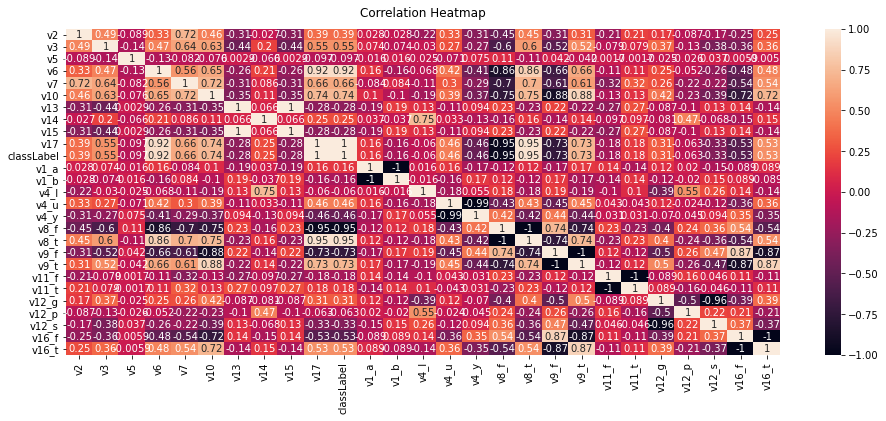

In [20]:
Var_Corr = OH_X_train.corr()
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it 
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(Var_Corr.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

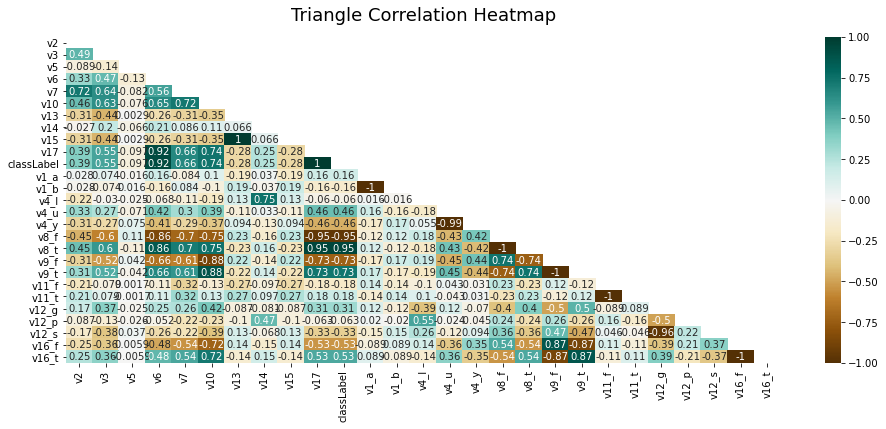

In [21]:
plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(Var_Corr.corr(), dtype=np.bool))
heatmap = sns.heatmap(Var_Corr.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

In [22]:
df_model_t = OH_X_train.drop(['v15','v17'], axis = 1)
#df_model_v = OH_X_valid.drop(['v15','v17'], axis = 1)

In [23]:
df_model_t.columns

Index(['v2', 'v3', 'v5', 'v6', 'v7', 'v10', 'v13', 'v14', 'classLabel', 'v1_a',
       'v1_b', 'v4_l', 'v4_u', 'v4_y', 'v8_f', 'v8_t', 'v9_f', 'v9_t', 'v11_f',
       'v11_t', 'v12_g', 'v12_p', 'v12_s', 'v16_f', 'v16_t'],
      dtype='object')

In [24]:
scaler = MinMaxScaler()
# copy the data
df_model_scaled_t = df_model_t.copy()
df_model_scaled_t[['v2', 'v3', 'v5', 'v6', 'v7', 'v10', 'v13', 'v14', 'classLabel', 'v1_a',
       'v1_b', 'v4_l', 'v4_u', 'v4_y', 'v8_f', 'v8_t', 'v9_f', 'v9_t', 'v11_f',
       'v11_t', 'v12_g', 'v12_p', 'v12_s', 'v16_f', 'v16_t']] = scaler.fit_transform(df_model_scaled_t)
#df_model_scaled_v = df_model_v.copy()
#df_model_scaled_v[['v2', 'v3', 'v5', 'v6', 'v7', 'v10', 'v13', 'v14', 'classLabel', 'v1_a',
#       'v1_b', 'v4_l', 'v4_u', 'v4_y', 'v8_f', 'v8_t', 'v9_f', 'v9_t', 'v11_f',
#       'v11_t', 'v12_g', 'v12_p', 'v12_s', 'v16_f', 'v16_t']] = scaler.fit_transform(df_model_scaled_v)
#df_model_scaled_v.head(2)

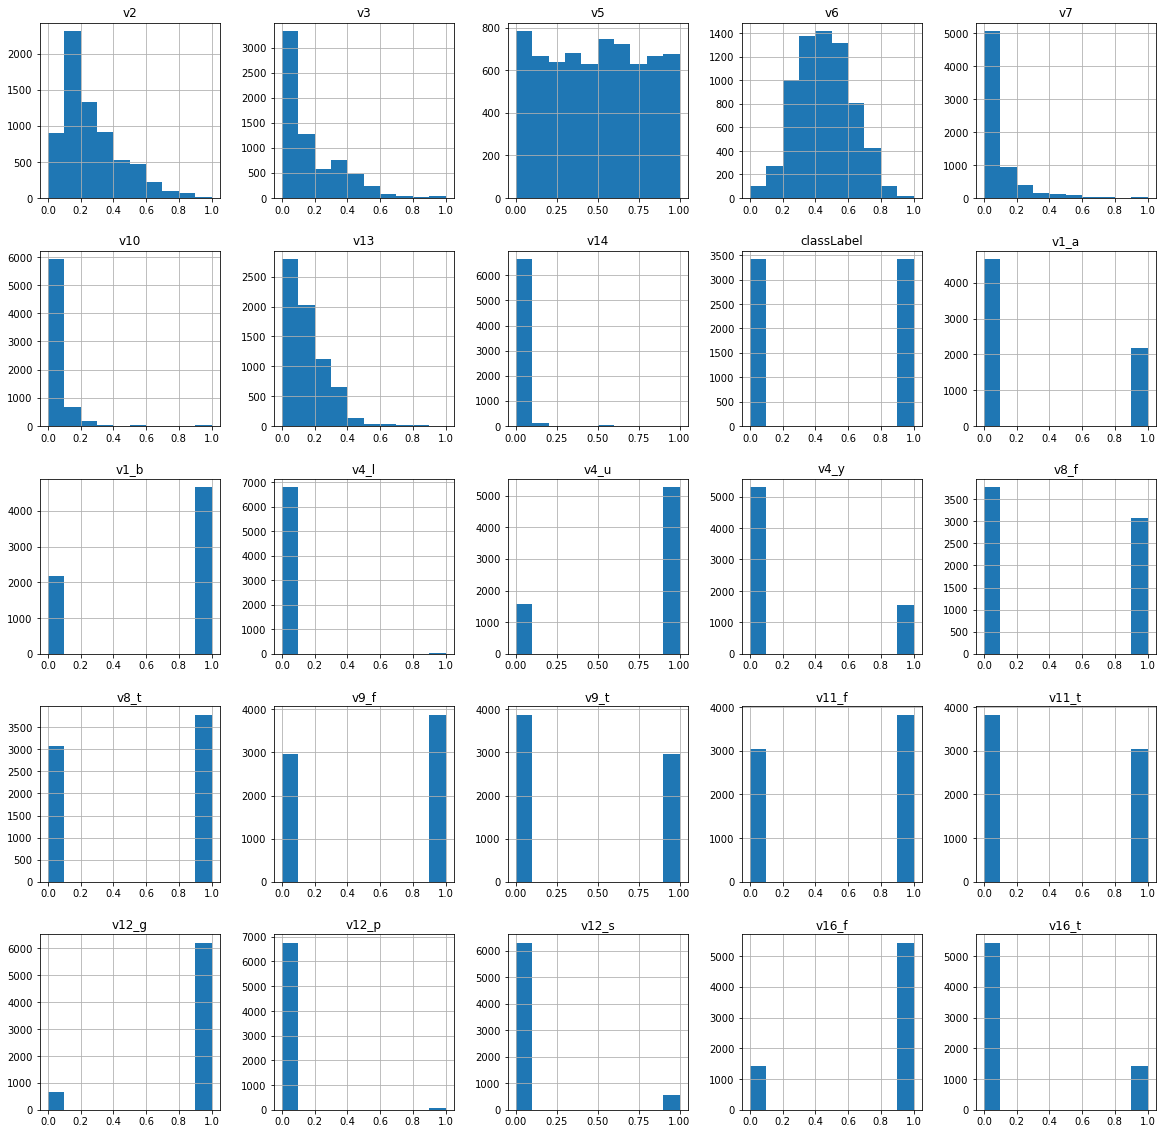

In [25]:
df_model_scaled_t.hist(figsize=(20,20))
plt.show()

## Data engineering for ML

In [26]:
# Separate input features (X) and target variable (y)
y_train = df_model_scaled_t["classLabel"].values
X_train = df_model_scaled_t.drop('classLabel', axis=1).values

#y_test = df_model_scaled_v["classLabel"].values
#X_test = df_model_scaled_v.drop('classLabel', axis=1).values

print(X_train.shape)
print(y_train.shape)
#print(X_test.shape)
#print(y_test.shape)

(6848, 24)
(6848,)


## Test Data

Hi, Rachana G V D, as Iris said u should not train imputer or one hot encoder on test data, u should train it only on train data, then just use it for test data. (just transform test data with OH_encoder instead of fit_transforming it)😊

In [ ]:
def data_eng(df, label):
    object_cols = df.select_dtypes(include=['object']).columns
    low_cardinality_cols = [col for col in object_cols if df[col].nunique() < 10]
    high_cardinality_cols = list(set(object_cols)-set(low_cardinality_cols))
    df[label]= np.where(df[label] == "no.", 0, 1)
    imputed_df_t = pd.DataFrame(imputer.fit_transform(df))
    imputed_df_t.columns = df.columns
    OH_cols_valid = pd.DataFrame(OH_encoder.transform(imputed_df_t[low_cardinality_cols]))
    OH_cols_valid.index = imputed_df_t.index
    OH_cols_valid.columns = OH_encoder.get_feature_names(low_cardinality_cols)
    num_X_valid = imputed_df_t.drop(object_cols, axis=1)
    OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)
    for object_cols in OH_X_valid:
        OH_X_valid[object_cols] = OH_X_valid[object_cols].astype(float, errors = 'raise')
    df_model_v = OH_X_valid.drop(['v15','v17'], axis = 1)
    df_model_scaled_v = df_model_v.copy()
    df_model_scaled_v[['v2', 'v3', 'v5', 'v6', 'v7', 'v10', 'v13', 'v14', 'classLabel', 'v1_a',
           'v1_b', 'v4_l', 'v4_u', 'v4_y', 'v8_f', 'v8_t', 'v9_f', 'v9_t', 'v11_f',
           'v11_t', 'v12_g', 'v12_p', 'v12_s', 'v16_f', 'v16_t']] = scaler.fit_transform(df_model_scaled_v)
    y_test = df_model_scaled_v["classLabel"].values
    X_test = df_model_scaled_v.drop('classLabel', axis=1).values
    return X_test, ytest

In [29]:
df_test = pd.read_csv('GFK validation2.csv',keep_default_na = True, encoding='latin-1')
df_test["classLabel"]= np.where(df_test["classLabel"] == "no.", 0, 1)
imputed_df_t = pd.DataFrame(imputer.fit_transform(df_test))
imputed_df_t.columns = df_test.columns
OH_cols_valid = pd.DataFrame(OH_encoder.transform(imputed_df_t[low_cardinality_cols]))
OH_cols_valid.index = imputed_df_t.index
OH_cols_valid.columns = OH_encoder.get_feature_names(low_cardinality_cols)
num_X_valid = imputed_df_t.drop(object_cols, axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)
for object_cols in OH_X_valid:
    OH_X_valid[object_cols] = OH_X_valid[object_cols].astype(float, errors = 'raise')
df_model_v = OH_X_valid.drop(['v15','v17'], axis = 1)
df_model_scaled_v = df_model_v.copy()
df_model_scaled_v[['v2', 'v3', 'v5', 'v6', 'v7', 'v10', 'v13', 'v14', 'classLabel', 'v1_a',
       'v1_b', 'v4_l', 'v4_u', 'v4_y', 'v8_f', 'v8_t', 'v9_f', 'v9_t', 'v11_f',
       'v11_t', 'v12_g', 'v12_p', 'v12_s', 'v16_f', 'v16_t']] = scaler.fit_transform(df_model_scaled_v)
y_test = df_model_scaled_v["classLabel"].values
X_test = df_model_scaled_v.drop('classLabel', axis=1).values
print(X_test.shape)
print(y_test.shape)

(200, 24)
(200,)


In [30]:
# Instantiate the classfiers and make a list
classifiers = [LogisticRegression(random_state=1234), 
               GaussianNB(), 
               KNeighborsClassifier(), 
               DecisionTreeClassifier(),
               RandomForestClassifier()]

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    model = cls.fit(X_train, y_train)
    yproba = model.predict_proba(X_test)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

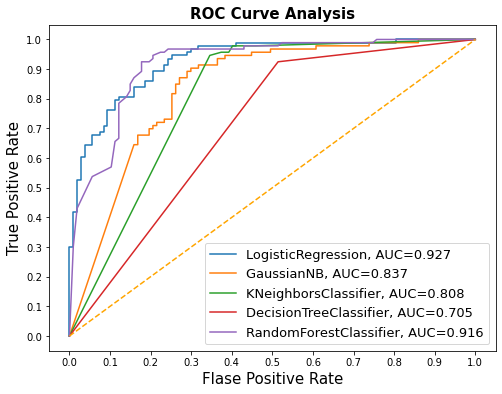

In [31]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

# Calculate K fold:

how do we decide the value of ‘k’?

Maybe we should use k = 1 so that we will get very good results on our training data? That might work, but we cannot guarantee that the model will perform just as well on our testing data since it can get too specific
How about using a high value of k, say like k = 100 so that we can consider a large number of nearest points to account for the distant points as well? However, this kind of model will be too generic and we cannot be sure if it has considered all the possible contributing features correctly.
Let us take a few possible values of k and fit the model on the training data for all those values. We will also compute the training score and testing score for all those values.

In [32]:
train_score = []
test_score = []
k_vals = []

for k in range(1, 21):
    k_vals.append(k)
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    
    tr_score = knn.score(X_train, y_train)
    train_score.append(tr_score)
    
    te_score = knn.score(X_test, y_test)
    test_score.append(te_score)

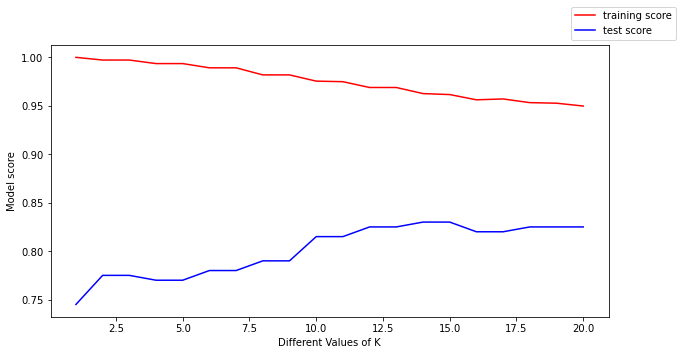

In [33]:
plt.figure(figsize=(10,5))
plt.xlabel('Different Values of K')
plt.ylabel('Model score')
plt.plot(k_vals, train_score, color = 'r', label = "training score")
plt.plot(k_vals, test_score, color = 'b', label = 'test score')
plt.legend(bbox_to_anchor=(1, 1),
           bbox_transform=plt.gcf().transFigure)
plt.show()

In [34]:
# Find best score for K
knn = KNeighborsClassifier(n_neighbors = 10)

#Fit the model
knn.fit(X_train,y_train)

#get the score
print('For K = 10 the Score =', knn.score(X_test,y_test))

For K = 10 the Score = 0.815


In [35]:
#create an array of models
models = []
models.append(("LR",LogisticRegression()))
models.append(("NB",GaussianNB()))
models.append(("RF",RandomForestClassifier()))
models.append(("SVC",SVC()))
models.append(("Dtree",DecisionTreeClassifier()))
models.append(("XGB",xgb.XGBClassifier()))
models.append(("KNN",KNeighborsClassifier()))


# Data frame for evaluation metrics
metrics = pd.DataFrame(index=['Accuracy','Average expected loss', 'Average bias', 'Average variance', 
                              'RMSE on train data', 'RMSE on test data', 'R2 Score'], 
                      columns=['LR','NB', 'RF', 'SVC','Dtree','XGB','KNN'])

#measure the accuracy 
for name,model in models:
    kfold = KFold(n_splits= 10 #, random_state=22
                 )
    cv_result = cross_val_score(model,X_train,y_train, cv = kfold,scoring = "accuracy")
    #print(name, cv_result.max())
    # estimating the bias and variance
    avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(model, X_train,
                                                            y_train, X_test,
                                                            y_test,
                                                            loss='mse',
                                                            num_rounds=50,
                                                            random_seed=20)
    # fit the model with the training data
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    
    # predict the target on train and test data
    predict_train = model.predict(X_train)
    y_pred = model.predict(X_test)

    # summary of the results
    # 4. Evaluate the model
    metrics.loc['Average expected loss',name] = round(avg_expected_loss*100,2)
    metrics.loc['Average bias',name] = round(avg_bias*100,2)
    metrics.loc['Average variance',name] = round(avg_var*100,2)
    metrics.loc['Accuracy',name] = round(cv_result.max()*100,2)
    
    # Root Mean Squared Error on train and test data (Perfect Model RMSE = 0)
    metrics.loc['RMSE on train data',name] = mean_squared_error(y_train, predict_train)**(0.5)
    metrics.loc['RMSE on test data',name] = mean_squared_error(y_test, y_pred)**(0.5)
    # R2 Score (Perfect Model R2 = 100)
    metrics.loc['R2 Score',name] = round(r2_score(y_test, y_pred, multioutput='variance_weighted')*100, 2)
    
metrics

[10:23:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:23:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:23:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:23:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[10:24:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:24:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:24:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:24:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[10:25:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:25:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:25:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:25:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

LR        NB        RF      SVC     Dtree  \
Accuracy                  91.97     98.69     100.0    93.71     100.0   
Average expected loss      22.4     22.27     23.64    17.18     32.03   
Average bias              21.89     22.08      22.4    16.25     24.95   
Average variance           0.51      0.19      1.24     0.93      7.08   
RMSE on train data     0.304992  0.493977       0.0  0.25606       0.0   
RMSE on test data      0.474342  0.474342  0.494975  0.41833  0.543139   
R2 Score                   9.56      9.56      1.52    29.66    -18.58   

                            XGB       KNN  
Accuracy                  100.0     100.0  
Average expected loss     20.53     22.09  
Average bias               19.2     20.52  
Average variance           1.33      1.57  
RMSE on train data          0.0  0.080158  
RMSE on test data      0.452769  0.479583  
R2 Score                   17.6      7.55

*The model has high bias but low variance, as it was unable to fit the relationship between the variables, but works similar for even the independent datasets.* 

### Fixing High Bias
> Adding more input features will help improve the data to fit better.

> Add more polynomial features to improve the complexity of the model.

> Decrease the regularization term to have a balance between bias and variance.

### Fixing High Variance
> Reduce the input features, use only features with more feature importance to reduce overfitting the data.

> Getting more training data will help in this case, because the high variance model will not be working for an independent dataset if you have very data.

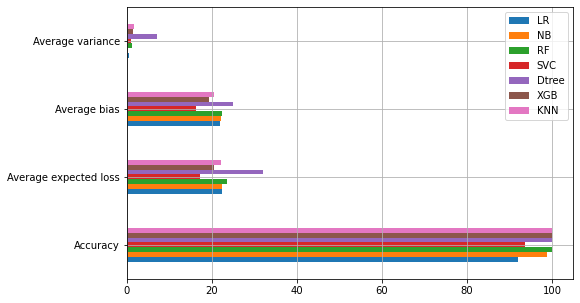

In [36]:
metrics_II = metrics.drop(['RMSE on train data', 'RMSE on test data', 'R2 Score'])
fig, ax = plt.subplots(figsize=(8,5))
metrics_II.plot(kind='barh', ax=ax)
plt.legend(loc=1)
ax.grid();

In [37]:
#create an array of models
models = []
models.append(("LR",LogisticRegression()))
models.append(("NB",GaussianNB()))
models.append(("RF",RandomForestClassifier()))
models.append(("SVC",SVC()))
models.append(("Dtree",DecisionTreeClassifier()))
models.append(("XGB",xgb.XGBClassifier()))
models.append(("KNN",KNeighborsClassifier()))


#measure the accuracy 
for name,model in models:
    kfold = KFold(n_splits=3 #, random_state=22
                 )
    cv_result = cross_val_score(model,X_train,y_train, cv = kfold,scoring = "accuracy")
    print(name, cv_result.max())
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    confusion = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix\n')
    print(confusion)
    print('------------------------------------')

LR 0.9132720105124835
              precision    recall  f1-score   support

         0.0       0.97      0.60      0.74       107
         1.0       0.68      0.98      0.80        93

    accuracy                           0.78       200
   macro avg       0.82      0.79      0.77       200
weighted avg       0.83      0.78      0.77       200

Confusion Matrix

[[64 43]
 [ 2 91]]
------------------------------------
NB 0.9688869412795793
              precision    recall  f1-score   support

         0.0       0.82      0.74      0.78       107
         1.0       0.73      0.82      0.77        93

    accuracy                           0.78       200
   macro avg       0.78      0.78      0.77       200
weighted avg       0.78      0.78      0.78       200

Confusion Matrix

[[79 28]
 [17 76]]
------------------------------------
RF 0.9986859395532195
              precision    recall  f1-score   support

         0.0       0.96      0.60      0.74       107
         1.0       0.68

In the first column, first row the learning curve of a naive Bayes classifier is shown for the digits dataset. Note that the training score and the cross-validation score are both not very good at the end. However, the shape of the curve can be found in more complex datasets very often: the training score is very high at the beginning and decreases and the cross-validation score is very low at the beginning and increases. In the second column, first row we see the learning curve of an SVM with RBF kernel. We can see clearly that the training score is still around the maximum and the validation score could be increased with more training samples. The plots in the second row show the times required by the models to train with various sizes of training dataset. The plots in the third row show how much time was required to train the models for each training sizes.

In [38]:
X = X_train.copy()
y = y_train.copy()

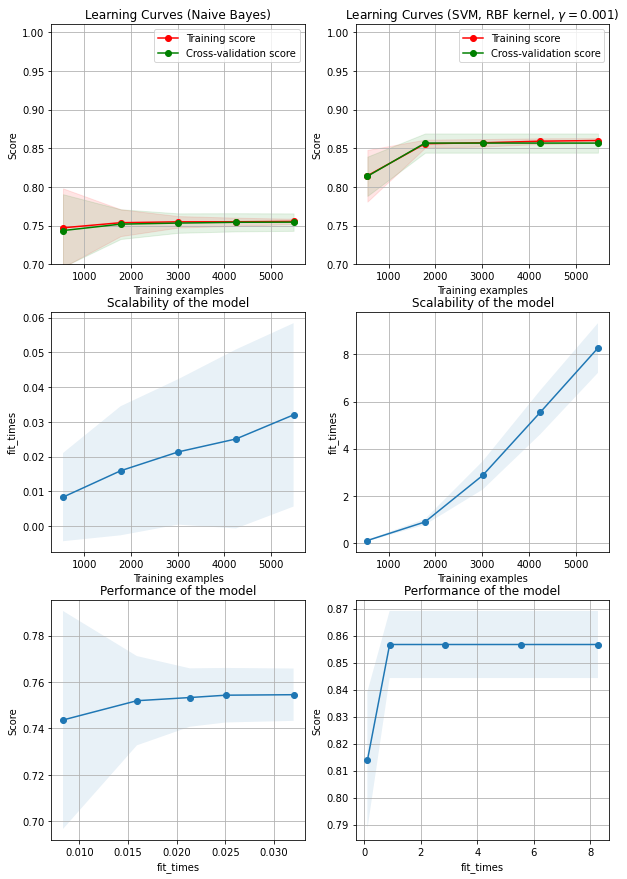

In [39]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, "o-")
    axes[2].fill_between(
        fit_times_mean,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 2, figsize=(10, 15))

#X, y = load_digits(return_X_y=True)


title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = GaussianNB()
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 0], ylim=(0.7, 1.01), cv=cv, n_jobs=4
)

title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 1], ylim=(0.7, 1.01), cv=cv, n_jobs=4
)

plt.show()

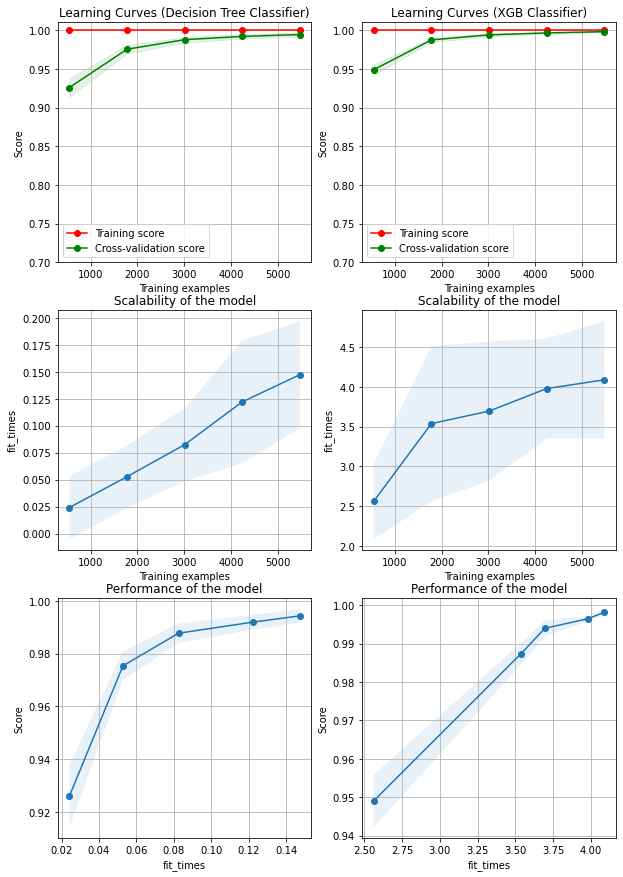

In [40]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

title = "Learning Curves (Decision Tree Classifier)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = DecisionTreeClassifier()
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 0], ylim=(0.7, 1.01), cv=cv, n_jobs=4
)

title = r"Learning Curves (XGB Classifier)"
# XGB Classifier is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = xgb.XGBClassifier()
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 1], ylim=(0.7, 1.01), cv=cv, n_jobs=4
)

plt.show()

In [41]:
df_model_scaled_t.columns

Index(['v2', 'v3', 'v5', 'v6', 'v7', 'v10', 'v13', 'v14', 'classLabel', 'v1_a',
       'v1_b', 'v4_l', 'v4_u', 'v4_y', 'v8_f', 'v8_t', 'v9_f', 'v9_t', 'v11_f',
       'v11_t', 'v12_g', 'v12_p', 'v12_s', 'v16_f', 'v16_t'],
      dtype='object')

In [42]:
df_model_scaled_t = df_model_scaled_t.drop(['v16_f', 'v16_t'], axis=1)
df_model_scaled_v = df_model_scaled_v.drop(['v16_f', 'v16_t'], axis=1)
y_train = df_model_scaled_t["classLabel"].values
X_train = df_model_scaled_t.loc[:, df_model_scaled_t.columns != "classLabel"].values
y_test = df_model_scaled_v["classLabel"].values
X_test = df_model_scaled_v.loc[:, df_model_scaled_v.columns != "classLabel"].values

In [43]:
#create an array of models
models = []
models.append(("LR",LogisticRegression()))
models.append(("NB",GaussianNB()))
models.append(("RF",RandomForestClassifier()))
models.append(("SVC",SVC()))
models.append(("Dtree",DecisionTreeClassifier()))
models.append(("XGB",xgb.XGBClassifier()))
models.append(("KNN",KNeighborsClassifier()))


# Data frame for evaluation metrics
metrics = pd.DataFrame(index=['Accuracy','Average expected loss', 'Average bias', 'Average variance', 
                              'RMSE on train data', 'RMSE on test data', 'R2 Score'], 
                      columns=['LR','NB', 'RF', 'SVC','Dtree','XGB','KNN'])

#measure the accuracy 
for name,model in models:
    kfold = KFold(n_splits=3 #, random_state=22
                 )
    cv_result = cross_val_score(model,X_train,y_train, cv = kfold,scoring = "accuracy")
    #print(name, cv_result.max())
    # estimating the bias and variance
    avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(model, X_train,
                                                            y_train, X_test,
                                                            y_test,
                                                            loss='mse',
                                                            num_rounds=50,
                                                            random_seed=20)
    # fit the model with the training data
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    
    # predict the target on train and test data
    predict_train = model.predict(X_train)
    y_pred = model.predict(X_test)

    # summary of the results
    # 4. Evaluate the model
    metrics.loc['Average expected loss',name] = round(avg_expected_loss*100,2)
    metrics.loc['Average bias',name] = round(avg_bias*100,2)
    metrics.loc['Average variance',name] = round(avg_var*100,2)
    metrics.loc['Accuracy',name] = round(cv_result.max()*100,2)
    
    # Root Mean Squared Error on train and test data (Perfect Model RMSE = 0)
    metrics.loc['RMSE on train data',name] = mean_squared_error(y_train, predict_train)**(0.5)
    metrics.loc['RMSE on test data',name] = mean_squared_error(y_test, y_pred)**(0.5)
    # R2 Score (Perfect Model R2 = 100)
    metrics.loc['R2 Score',name] = round(r2_score(y_test, y_pred, multioutput='variance_weighted')*100, 2)
    
metrics

[10:34:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:34:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:34:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:34:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[10:35:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:35:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:35:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:35:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

LR        NB     RF      SVC     Dtree       XGB  \
Accuracy                   90.8     96.45  99.91    93.82     99.34     100.0   
Average expected loss     22.67      22.6  23.69    17.13     32.14     20.57   
Average bias              22.25     22.33  22.44    16.35     25.01     19.21   
Average variance           0.42      0.27   1.24     0.78      7.13      1.36   
RMSE on train data     0.308798  0.505807    0.0  0.25463       0.0       0.0   
RMSE on test data      0.474342  0.479583    0.5  0.41833  0.556776  0.441588   
R2 Score                   9.56      7.55  -0.49    29.66    -24.61     21.62   

                            KNN  
Accuracy                  97.85  
Average expected loss     22.53  
Average bias               21.0  
Average variance           1.53  
RMSE on train data     0.082845  
RMSE on test data      0.484768  
R2 Score                   5.54

## PG

In [ ]:
df[df['CustomerID'] == 219]

In [ ]:
#You could use loc to get series and then iloc to get first element:
df.loc[df['CustomerID'] == 219, 'Customer_Code'].iloc[0]

In [ ]:
#You could use loc to get series and then iloc to get first element:
df.loc[df['CustomerID'] == 219, 'Country'].iloc[0]

In [ ]:
# You could use loc to get series:
df.loc[df['CustomerID'] == 219, 'Product_Code']